## 프로젝트 아이디어 개요

# 문제점:
Coding Test를 Gemma 모델에 input으로 넣었을 때, 예시 답변을 통해 알 수 있는 사실
1. 일관되지 않은 답변 방식
- 세 가지 질문 중에 일부는 설명만 제공하고, 일부는 코드까지 포함한 정답을 제공하는 등 답변 형식이 일관되지 X
2. 코드 제공의 부재 및 오답 예시

결론적으로 Gemma 모델의 경우 일관적이지 않은 답변을 제공함으로써, 사용자 학습에 도움이 되지 않을 가능성이 높음.

# 목표:

- Gemma 모델을 파인튜닝하여 Coding Test 문제에 대한 직접적인 답변 제공이 아닌, 문제 해결 과정을 지원하고, 힌트를 통해 사용자의 사고를 유도하는 시스템을 구축하는 것.

- 이 시스템은 학습자가 문제를 직접 풀도록 이끌고, 스스로 답을 찾게 함으로써 학습 과정에서 LLM에 의존하는 대신 스스로 생각하는 능력을 강화하는 것을 목표로 합니다.

## 구체적인 기능 및 구조

- 사용자가 Coding Test 문제를 제출하면, Gemma 모델이 바로 정답을 제공하는 대신, 문제를 분석하고 여러 가지 단계적인 힌트를 제공합니다.
- 예를 들어:
    - 첫 번째 질문: "이 문제는 어떤 알고리즘을 사용해야 할까요?"
    - 두 번째 질문: "문제를 풀기 위해 필요한 데이터 구조는 무엇인가요?"
    - 세 번째 질문: "이 문제에서 중요한 조건은 무엇인가요?"
- 이처럼 사용자가 스스로 문제를 해결할 수 있도록 필요한 사고의 흐름을 유도합니다.

Project Title:
ThinkLink: A Guided Problem-Solving System for Coding Tests

Project Description:
ThinkLink is a fine-tuned version of the Gemma model designed to assist users in solving coding test problems by guiding them through the problem-solving process rather than directly providing answers. The system promotes independent thinking by offering structured hints that lead the user through critical reasoning steps. Instead of relying on the model for complete solutions, users are encouraged to reflect on their approach to algorithms, data structures, and problem constraints.

Key features include:

Gradual hint-based guidance, prompting users with questions like "What algorithm would you use?" or "What data structures are relevant?"
Encouragement of self-reflection and problem analysis, helping users improve their coding skills without over-relying on the model.
A focus on building problem-solving strategies, fostering deeper understanding and long-term retention of coding concepts.
By focusing on thought processes, ThinkLink aims to enhance the learning experience and empower users to become more independent problem solvers.

# Import Modules

In [1]:
!pip install -q -U torch --index-url https://download.pytorch.org/whl/cu117
!pip install -q -U -i https://pypi.org/simple/ bitsandbytes
!pip install -q -U transformers
!pip install -q -U accelerate
!pip install -q -U datasets
!pip install -q -U trl
!pip install -q -U peft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.1/280.1 kB 1

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import warnings
warnings.filterwarnings("ignore")

import re
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch

import numpy as np
import pandas as pd
import os
from tqdm import tqdm

import torch
import torch.nn as nn

import transformers
from transformers import (AutoModelForCausalLM,
                          AutoTokenizer,
                          BitsAndBytesConfig,
                          TrainingArguments,
                          )

from datasets import Dataset
from peft import LoraConfig, PeftConfig
import bitsandbytes as bnb
from trl import SFTTrainer

In [3]:
def define_device():
    """Define the device to be used by PyTorch"""

    # Get the PyTorch version
    torch_version = torch.__version__

    # Print the PyTorch version
    print(f"PyTorch version: {torch_version}", end=" -- ")

    # Check if MPS (Multi-Process Service) device is available on MacOS
    if torch.backends.mps.is_available():
        # If MPS is available, print a message indicating its usage
        print("using MPS device on MacOS")
        # Define the device as MPS
        defined_device = torch.device("mps")
    else:
        # If MPS is not available, determine the device based on GPU availability
        defined_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # Print a message indicating the selected device
        print(f"using {defined_device}")

    # Return the defined device
    return defined_device


# Pre-compile the regular expression pattern for better performance
BRACES_PATTERN = re.compile(r'\{.*?\}|\}')

def remove_braces_and_content(text):
    """Remove all occurrences of curly braces and their content from the given text"""
    return BRACES_PATTERN.sub('', text)

def clean_string(input_string):
    """Clean the input string."""

    # Remove extra spaces by splitting the string by spaces and joining back together
    cleaned_string = ' '.join(input_string.split())

    # Remove consecutive carriage return characters until there are no more consecutive occurrences
    cleaned_string = re.sub(r'\r+', '\r', cleaned_string)

    # Remove all occurrences of curly braces and their content from the cleaned string
    cleaned_string = remove_braces_and_content(cleaned_string)

    # Return the cleaned string
    return cleaned_string

# Load Dataset

In [4]:
from datasets import load_dataset

ds = load_dataset("RayBernard/leetcode")
ds

Generating train split:   0%|          | 0/2359 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output', 'text'],
        num_rows: 2359
    })
})

In [5]:
"""
instruction : Create a solution in python for the input asked.
input : Problem -> 문제 해결에 필요한 세부 정보
output : Answer
text : instruction, input, output을 모두 하나의 text로 묶어 놓음
"""

data = ds['train']

Example of 'input'(question) and 'output'(answer)

In [6]:
data['input'][100]

"The algorithm works by comparing the left subtree and right subtree of the root node. It uses a helper function, 'checkSymmetry()', which takes two nodes as its arguments. The base cases for this helper function are when both nodes are null, in which case the function should return true, or when one of the nodes is null, in which case the function should return false.\n\nThe function then checks whether the values of both nodes are equal and continues to call itself recursively, but with the arguments changed to evaluate the left subtree and right subtree symmetrically. If the left and right subtrees have symmetric nodes, the function will return true; otherwise, it will return false.\n\nThe recursive calls in the helper function flip the direction of traversal for both subtrees to ensure that the subtrees are compared symmetrically. In each recursive call, the appropriate child nodes are visited in opposite directions to make sure they can be properly compared."

In [7]:
data['output'][100]

'```python\ndef isSymmetric(root):\n    return checkSymmetry(root, root)\n\ndef checkSymmetry(node1, node2):\n    if not node1 and not node2:\n        return True\n    if not node1 or not node2:\n        return False\n    return (node1.val == node2.val) and checkSymmetry(node1.right, node2.left) and checkSymmetry(node1.left, node2.right)\n```\n\n'

In [8]:
from huggingface_hub import notebook_login
notebook_login()

- Gemma의 Instruct Tuned 모델 사용
  - 대화 형식의 상호작용에 최적화되어 있어 사용자의 의도를 정확하게 파악하여 정제된 답변을 제공 (Base모델 보다 출력 품질 높음)
  - https://devocean.sk.com/blog/techBoardDetail.do?ID=165703&boardType=techBlog


- Dataset의 길이

  - min = 35
  - max = 510
  - mean = 170.91691394658753

- 즉, max_seq_length = 512 설정 가능

In [9]:
model_name = "google/gemma-2-2b-it"
compute_dtype = getattr(torch, "float16")

# 양자화(Quantization) -> 모델 size Down, 계산 속도 Up, Memory Usage Down
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True, # 모델을 4bit로 양자화
    bnb_4bit_use_double_quant=False, # 이중 양자화 사용 X
    bnb_4bit_quant_type="nf4", # 양자화 방식으로 Normal Float 4 사용
    bnb_4bit_compute_dtype=compute_dtype,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    quantization_config=bnb_config,
)

model.config.use_cache = False
model.config.pretraining_tp = 1

max_seq_length = 1024
tokenizer = AutoTokenizer.from_pretrained(model_name, max_seq_length=max_seq_length)

# 텍스트의 길이를 계산
lengths = [len(tokenizer.encode(text)) for text in data['input']]

# min, max, mean 값 출력
min_length = min(lengths)
max_length = max(lengths)
mean_length = sum(lengths) / len(lengths)

print(f"Min length: {min_length}")
print(f"Max length: {max_length}")
print(f"Mean length: {mean_length}")

config.json:   0%|          | 0.00/838 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/24.2k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/241M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/187 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/47.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

Min length: 35
Max length: 510
Mean length: 170.91691394658753


In [10]:
model_name = "google/gemma-2-2b-it"

# 모델 계산 시 사용할 데이터 유형 설정
compute_dtype = getattr(torch, "float16") # -> 계산 속도 향상, 메모리 사용량 감소

# 양자화(Quantization) -> 모델 size Down, 계산 속도 Up, Memory Usage Down
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True, # 모델을 4bit로 양자화
    bnb_4bit_use_double_quant=False, # 이중 양자화 사용 X
    bnb_4bit_quant_type="nf4", # 양자화 방식으로 Normal Float 4 사용
    bnb_4bit_compute_dtype=compute_dtype,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    quantization_config=bnb_config,
)

model.config.use_cache = False
model.config.pretraining_tp = 1

# 토크나이저가 텍스트 데이터를 처리할 때 사용할 최대 토큰 시퀀스 길이를 지정 (넘어가면 잘릴 수 있음)
max_seq_length = 512
tokenizer = AutoTokenizer.from_pretrained(model_name, max_seq_length=max_seq_length)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [11]:
def question_gemma(question, model=model, tokenizer=tokenizer, temperature=0.0, return_answer=False):
    """
    주어진 질문에 대해 모델을 사용해 답변을 생성하는 기능
    1. 질문 토큰화 (tokenizer), 토큰이라는 단위로 나누는 작업
    2. 샘플링 여부 결정, temperature 값에 따라 do_sample의 사용 여부 결정
    3. 모델을 사용해 출력 생성 (model.generate()), max_new_tokens=256은 생성된 텍스트의 최대 토큰 수 제한
    4. 결과 Decoding, 사람이 읽을 수 있는 문자열로 변환
    """
    input_ids = tokenizer(question, return_tensors="pt").to("cuda")
    if temperature > 0:
        do_sample=True
    else:
        do_sample=False
    outputs = model.generate(**input_ids,
                             max_new_tokens=2024,
                             do_sample=do_sample,
                             temperature=temperature)
    result = str(tokenizer.decode(outputs[0])).replace("<bos>", "").replace("<eos>", "").strip()
    if return_answer:
        return result
    else:
        print(result)

아래와 같이 답변만 도출되는 것을 확인 가능!

1. 알고리즘 설명
2. 원리 설명 (코드 제공 X)
3. 예시 제공
4. 정답 코드 X

In [12]:
question_gemma(data['input'][100])

The algorithm works by comparing the left subtree and right subtree of the root node. It uses a helper function, 'checkSymmetry()', which takes two nodes as its arguments. The base cases for this helper function are when both nodes are null, in which case the function should return true, or when one of the nodes is null, in which case the function should return false.

The function then checks whether the values of both nodes are equal and continues to call itself recursively, but with the arguments changed to evaluate the left subtree and right subtree symmetrically. If the left and right subtrees have symmetric nodes, the function will return true; otherwise, it will return false.

The recursive calls in the helper function flip the direction of traversal for both subtrees to ensure that the subtrees are compared symmetrically. In each recursive call, the appropriate child nodes are visited in opposite directions to make sure they can be properly compared.

The algorithm continues re

1. 알고리즘 설명
2. 예시 코드
3. 예시 제공
4. 정답 코드 제공


In [ ]:
question_gemma(data['input'][15])

1. Sort the input array `nums`.
2. Initialize the `closest` variable to be the sum of the first three elements.
3. Iterate through the sorted array with a pointer `i` running from the first element to the third-to-last element.
4. Initialize two-pointers `left` (set to `i + 1`) and `right` (set to the last element).
5. While `left` is less than `right`:
    a. Calculate the current sum `cur_sum` using the elements at positions `i`, `left`, and `right`.
    b. If `cur_sum` is equal to `target`, return it as the closest sum.
    c. Update the `closest` sum if the difference between `target` and `cur_sum` is less than the difference between `target` and `closest`.
    d. Move the `left` pointer forward if `cur_sum` is less than `target`, otherwise move the `right` pointer backward.
6. Return the `closest` sum found.

**Explanation:**

The code implements a solution to find the closest sum of three numbers in an array. It utilizes a two-pointer approach to efficiently explore the array and

1. 알고리즘 설명
2. 예시 코드 제공 X
3. 예시 오류

In [13]:
question_gemma(data['input'][2])

The algorithm uses a sliding window with two pointers, left and right, to iterate through the string. It also uses a set to store the unique characters in the current window.

1. Initialize left and right pointers to the start of the string, and maxLength to 0.
2. Check if the character at the right index is in the set.
   - If it's not in the set, add the character to the set, update maxLength, and move the right pointer forward.
   - If it's in the set, remove the character at the left index from the set, and move the left pointer forward.
3. Repeat step 2 until the right pointer reaches the end of the string.
4. Return maxLength. 

The algorithm runs in O(n) time, where n is the length of the input string.

**Example:**

```
string s = "abcabc";
int maxLength = longestSubstring(s);
```

**Output:**

```
maxLength = 3
```

**Explanation:**

The longest substring is "abc". 
```
s = "abcabc"
```
```
left = 0
right = 0
maxLength = 0
```
```
s = "abcabc"
left = 0
right = 1
maxLength = 1


위 세 답변을 통해 알 수 있는 사실
1. 일관되지 않은 답변 방식
- 세 가지 질문 중에 일부는 설명만 제공하고, 일부는 코드까지 포함한 정답을 제공하는 등 답변 형식이 일관되지 X
2. 코드 제공의 부재 및 오답 예시

결론적으로 Gemma 모델의 경우 일관적이지 않은 답변을 제공함으로써, 사용자 학습에 도움이 되지 않을 가능성이 높음.

# Custom 데이터셋 생성

In [14]:
extracted_texts = data['input']

In [15]:
# Function to extract JSON block from the response
def extract_json_block(text):
    pattern = r'OUTPUT JSON:\s*```json(.*?)```'
    match = re.search(pattern, text, re.DOTALL)
    if match:
        return match.group(1).strip()
    else:
        return ""


def clean_json_block(text):
    # \n 뒤에 숫자와 마침표가 붙어 있는 경우 단순한 줄바꿈(\n)으로 교체
    text = re.sub(r'\n\d+\.', '\n', text)

    return text

Sample_test

In [ ]:
import re
import json

qa_data = []

no_extracted_texts = 3 # test
question_ratio = 24 # decrement this number to produce more questions (suggested: 24)

# 추가된 질문 리스트
thinking_questions = [
    "What type of problem do you think this is?",
    "What part of the problem do you find challenging?",
    "How do you plan to implement the solution? Describe the key steps in your code.",
]

for i in tqdm(range(len(extracted_texts[:no_extracted_texts]))):
    # 모든 질문을 하나의 텍스트로 연결
    questions_combined = "\n".join([f"{idx + 1}. {q}" for idx, q in enumerate(thinking_questions)])

    final_answer = data['output'][i]

    question_text = f"""Here is a problem description:
    {extracted_texts[i]}

    Please ONLY answer the following questions to help understand and solve the problem step by step (Avoid using special characters like \\n or lists (e.g., 1., 2.) and PLEASE Provide answers in plain text format):

    Questions:
    {questions_combined}

    OUTPUT JSON:
    """

    # print(question_text)


    no_questions = min(1, len(extracted_texts[i]) // question_ratio)

    # 한 번에 질문을 묻고 답변을 생성
    result = question_gemma(question_text, model=model, temperature=0.0, return_answer=True)

    # Extract the JSON block from the response
    json_block = extract_json_block(result)

    if json_block:
        try:
            # Clean the JSON block by fixing the patterns and invalid characters
            # json_block = clean_json_block(json_block)

            # Parse the cleaned json_block into a Python dictionary
            json_data = json.loads(json_block)

            # Add the "Answer Code" with the final_answer as the value
            json_data["Answer Code"] = final_answer

            # Convert back to JSON string
            formatted_json = json.dumps(json_data, indent=4)

            # Store question and answer in qa_data
            question = extracted_texts[i]
            answer = formatted_json

            qa_data.append(f"Q: {question}\nA: {answer}")
            print(f"Extracted QA Pair:\nQ: {question}\nA: {answer}\n")

        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")
            print(f"Problematic JSON block: {json_block}")
    else:
        print("No JSON block found")

 33%|███▎      | 1/3 [00:12<00:25, 12.53s/it]

Extracted QA Pair:
Q: The algorithm leverages a hash map (unordered_map in C++, HashMap in Java, dictionary in Python, and Map in JavaScript). It iterates through the given 'nums' array and calculates the complementary value (target - current value). If the complementary value is already in the hash map, it means that we found a solution, and we return those indices. If the complement is not in the hash map, we store the current element in the hash map with its index. If the algorithm doesn't find the solution, it returns an empty array or throws an exception (in Java).

This approach has a time complexity of O(n) and a space complexity of O(n) as well.
A: {
    "problem_type": "Two Sum",
    "challenging_part": "Understanding the hash map implementation and finding the complementary value",
    "implementation": "Implement the hash map and iterate through the array to find the complementary value. If the complementary value is found, return the indices. If not, store the current eleme

 67%|██████▋   | 2/3 [00:23<00:11, 11.61s/it]

Extracted QA Pair:
Q: 1. Initialize a dummy ListNode with a value of 0.
2. Set current to that dummy ListNode, and set carry to 0.
3. Iterate over the list nodes of l1 and l2, as well as the carry, in a while loop until all are null or 0.
4. Calculate the sum of the node values and carry, store the carry for the next iteration, and store the value % 10 in a new ListNode connected to the current ListNode.
5. Shift the current ListNode, l1, and l2 to the next node if available.
6. Return the next of the dummy ListNode as a result.
A: {
    "problem_type": "addition",
    "challenging_part": "Understanding the logic of the loop and how to handle the carry",
    "implementation": "The code will iterate through the nodes of both lists and the carry, calculating the sum of the node values and carry. The result will be stored in a new ListNode connected to the current ListNode. The code will then shift the current ListNode, l1, and l2 to the next node if available. The code will return the ne

100%|██████████| 3/3 [00:30<00:00, 10.26s/it]

Extracted QA Pair:
Q: The algorithm uses a sliding window with two pointers, left and right, to iterate through the string. It also uses a set to store the unique characters in the current window.

1. Initialize left and right pointers to the start of the string, and maxLength to 0.
2. Check if the character at the right index is in the set.
   - If it's not in the set, add the character to the set, update maxLength, and move the right pointer forward.
   - If it's in the set, remove the character at the left index from the set, and move the left pointer forward.
3. Repeat step 2 until the right pointer reaches the end of the string.
4. Return maxLength. 

The algorithm runs in O(n) time, where n is the length of the input string.
A: {
    "problem_type": "Sliding Window",
    "challenging_part": "Understanding the logic behind the set and how it's used to track unique characters in the window",
    "implementation": "Implement the solution in Python, with clear comments explaining eac

답변 잘 생성되는 것 확인 완료

In [16]:
len(data)

2359

In [17]:
import re
import json
from tqdm import tqdm

qa_data = []

# no_extracted_texts = 2359  # Full_dataset
question_ratio = 24  # Decrement this number to produce more questions (suggested: 24)

# 추가된 질문 리스트
thinking_questions = [
    "What type of problem do you think this is?",
    "What part of the problem do you find challenging?",
    "How do you plan to implement the solution? Describe the key steps in your code.",
]

for i in tqdm(range(len(extracted_texts))):
    try:
        # 모든 질문을 하나의 텍스트로 연결
        questions_combined = "\n".join([f"{idx + 1}. {q}" for idx, q in enumerate(thinking_questions)])

        final_answer = data['output'][i]

        question_text = f"""Here is a problem description:
        {extracted_texts[i]}

        Please ONLY answer the following questions to help understand and solve the problem step by step (Avoid using special characters like \\n or lists (e.g., 1., 2.) and PLEASE Provide answers in plain text format):

        Questions:
        {questions_combined}

        OUTPUT JSON:
        """

        # 질문을 묻고 답변 생성
        result = question_gemma(question_text, model=model, temperature=0.0, return_answer=True)

        # Extract the JSON block from the response
        json_block = extract_json_block(result)

        if json_block:
            try:
                # Clean the JSON block by fixing the patterns and invalid characters
                # json_block = clean_json_block(json_block)

                # Parse the cleaned json_block into a Python dictionary
                json_data = json.loads(json_block)

                # Add the "Answer Code" with the final_answer as the value
                json_data["Answer Code"] = final_answer

                # Convert back to JSON string
                formatted_json = json.dumps(json_data, indent=4)

                # Store question and answer in qa_data
                question = extracted_texts[i]
                answer = formatted_json

                qa_data.append(f"Q: {question}\nA: {answer}")
                print('Successfully Extracted QA Pair!')
                # print(f"Extracted QA Pair:\nQ: {question}\nA: {answer}\n")

            except json.JSONDecodeError as e:
                print(f"Error decoding JSON: {e}")
                print(f"Problematic JSON block: {json_block}")
                # 문제 발생 시에도 데이터는 계속 저장
                qa_data.append(f"Q: {extracted_texts[i]}\nA: Error decoding JSON")
        else:
            print("No JSON block found")
            # qa_data.append(f"Q: {extracted_texts[i]}\nA: No JSON block found")

    except Exception as e:
        print(f"An error occurred while processing item {i}: {e}")
        # qa_data.append(f"Q: {extracted_texts[i]}\nA: Error occurred during processing")

  0%|          | 1/2359 [00:08<5:23:07,  8.22s/it]

Successfully Extracted QA Pair!


  0%|          | 2/2359 [00:18<6:10:56,  9.44s/it]

Successfully Extracted QA Pair!


  0%|          | 3/2359 [00:25<5:20:57,  8.17s/it]

Successfully Extracted QA Pair!


  0%|          | 4/2359 [00:38<6:38:23, 10.15s/it]

Successfully Extracted QA Pair!


  0%|          | 5/2359 [00:46<6:15:36,  9.57s/it]

Successfully Extracted QA Pair!


  0%|          | 6/2359 [00:54<5:52:03,  8.98s/it]

Successfully Extracted QA Pair!


  0%|          | 7/2359 [01:52<16:11:47, 24.79s/it]

Successfully Extracted QA Pair!


  0%|          | 8/2359 [02:29<18:54:11, 28.95s/it]

Successfully Extracted QA Pair!


  0%|          | 9/2359 [02:37<14:26:01, 22.11s/it]

Successfully Extracted QA Pair!


  0%|          | 10/2359 [03:21<18:57:54, 29.07s/it]

Successfully Extracted QA Pair!


  0%|          | 11/2359 [03:33<15:36:00, 23.92s/it]

Successfully Extracted QA Pair!


  1%|          | 12/2359 [03:43<12:51:09, 19.71s/it]

Successfully Extracted QA Pair!


  1%|          | 13/2359 [04:16<15:23:23, 23.62s/it]

Successfully Extracted QA Pair!


  1%|          | 14/2359 [04:27<12:53:19, 19.79s/it]

Successfully Extracted QA Pair!


  1%|          | 15/2359 [04:33<10:09:41, 15.61s/it]

Successfully Extracted QA Pair!


  1%|          | 16/2359 [04:45<9:32:08, 14.65s/it] 

Successfully Extracted QA Pair!


  1%|          | 17/2359 [07:23<37:34:42, 57.76s/it]

Successfully Extracted QA Pair!


  1%|          | 18/2359 [07:34<28:17:21, 43.50s/it]

Successfully Extracted QA Pair!


  1%|          | 19/2359 [08:38<32:19:54, 49.74s/it]

Successfully Extracted QA Pair!


  1%|          | 20/2359 [09:17<30:16:06, 46.59s/it]

Successfully Extracted QA Pair!


  1%|          | 21/2359 [10:12<31:49:50, 49.01s/it]

Successfully Extracted QA Pair!


  1%|          | 22/2359 [10:18<23:28:01, 36.15s/it]

Successfully Extracted QA Pair!


  1%|          | 23/2359 [10:27<18:09:49, 27.99s/it]

Successfully Extracted QA Pair!


  1%|          | 24/2359 [11:28<24:38:17, 37.99s/it]

Successfully Extracted QA Pair!


  1%|          | 25/2359 [11:56<22:38:06, 34.91s/it]

Successfully Extracted QA Pair!


  1%|          | 26/2359 [12:42<24:48:47, 38.29s/it]

Successfully Extracted QA Pair!


  1%|          | 27/2359 [13:30<26:37:19, 41.10s/it]

Successfully Extracted QA Pair!


  1%|          | 28/2359 [13:38<20:15:09, 31.28s/it]

Successfully Extracted QA Pair!


  1%|          | 29/2359 [14:10<20:20:51, 31.44s/it]

Successfully Extracted QA Pair!


  1%|▏         | 30/2359 [14:18<15:47:27, 24.41s/it]

Successfully Extracted QA Pair!


  1%|▏         | 31/2359 [14:50<17:13:49, 26.64s/it]

Successfully Extracted QA Pair!


  1%|▏         | 32/2359 [15:41<21:59:24, 34.02s/it]

Successfully Extracted QA Pair!


  1%|▏         | 33/2359 [16:36<26:05:52, 40.39s/it]

Successfully Extracted QA Pair!


  1%|▏         | 34/2359 [16:43<19:30:47, 30.21s/it]

Successfully Extracted QA Pair!


  1%|▏         | 35/2359 [17:21<21:06:23, 32.70s/it]

Successfully Extracted QA Pair!


  2%|▏         | 36/2359 [18:01<22:24:27, 34.73s/it]

Successfully Extracted QA Pair!


  2%|▏         | 37/2359 [19:17<30:28:56, 47.26s/it]

Successfully Extracted QA Pair!


  2%|▏         | 38/2359 [19:51<27:47:03, 43.10s/it]

Successfully Extracted QA Pair!


  2%|▏         | 39/2359 [20:00<21:08:52, 32.82s/it]

Successfully Extracted QA Pair!


  2%|▏         | 40/2359 [20:05<15:47:13, 24.51s/it]

Successfully Extracted QA Pair!


  2%|▏         | 41/2359 [20:43<18:23:51, 28.57s/it]

Successfully Extracted QA Pair!


  2%|▏         | 42/2359 [20:54<15:06:47, 23.48s/it]

Successfully Extracted QA Pair!


  2%|▏         | 43/2359 [21:48<21:00:43, 32.66s/it]

Successfully Extracted QA Pair!


  2%|▏         | 43/2359 [23:24<21:00:41, 32.66s/it]


KeyboardInterrupt: 

In [ ]:
# from tqdm import tqdm
# import torch

# qa_data = []

# def extract_json(text, word):
#     pattern = fr'"{word}": "(.*?)"'
#     match = re.search(pattern, text)
#     if match:
#         return match.group(1)
#     else:
#         return ""

# # no_extracted_texts = len(data)
# no_extracted_texts = 4
# question_ratio = 24 # decrement this number to produce more questions (suggested: 24)

# def process_batch(extracted_texts, final_answers, batch_size, model, tokenizer, question_ratio=24):
#     qa_data = []

#     # 추가된 질문 리스트
#     thinking_questions = [
#         "What type of problem do you think this is?",
#         "What is the core of this problem?",
#         "What kind of algorithm can be used to solve this problem?",
#         "Why would the chosen approach or algorithm work in this case?",
#         "What part of the problem do you find challenging?",
#         "What do you think about the Time Complexity and Space Complexity of your approach?",
#         "Tell me how you calculated Time Complexity and the Space Complexity.",
#         "How do you plan to implement the solution? Describe the key steps in your code.",
#         "Is there any way to optimize your solution for better efficiency?",
#         "What are the potential advantages of using a different algorithm or approach?",
#         "Finally, can you provide the complete solution."
#     ]

#     # 모든 질문을 미리 텍스트로 연결
#     combined_texts = []
#     for i in range(len(extracted_texts)):
#         questions_combined = "\n".join([f"{idx + 1}. {q}" for idx, q in enumerate(thinking_questions)])
#         final_answer = final_answers[i]
#         question_text = f"""Here is a problem description:
#         {extracted_texts[i]}

#         Please answer the following questions to help understand and solve the problem step by step:
#         {questions_combined}

#         At the end, the complete solution should be:
#         {final_answer}

#         OUTPUT JSON:
#         """
#         combined_texts.append(question_text)

#     # 모든 텍스트를 토큰화하고 배치로 나누기
#     tokenized_inputs = tokenizer(combined_texts, return_tensors="pt", padding=True, truncation=True, max_length=512)
#     input_ids_batches = tokenized_inputs["input_ids"].split(batch_size)
#     attention_mask_batches = tokenized_inputs["attention_mask"].split(batch_size)

#     for input_ids_batch, attention_mask_batch in tqdm(zip(input_ids_batches, attention_mask_batches), total=len(input_ids_batches)):
#         input_ids_batch = input_ids_batch.to("cuda")
#         attention_mask_batch = attention_mask_batch.to("cuda")

#         # 모델을 사용해 한 번에 배치 처리
#         outputs = model.generate(input_ids=input_ids_batch, attention_mask=attention_mask_batch, max_new_tokens=2024)

#         # 결과 디코딩
#         decoded_outputs = tokenizer.batch_decode(outputs, skip_special_tokens=True)

#         # 결과 처리
#         for result in decoded_outputs:
#             result = result.split("OUTPUT JSON:")[-1]
#             question = extract_json(result, "question")
#             answer = extract_json(result, "answer")
#             qa_data.append(f"Q: {question}\nA: {answer}")

#     return qa_data

# # 배치 사이즈 설정
# batch_size = 4

# # 미리 준비된 데이터 (extracted_texts는 문제 설명, data['output']는 해결책)
# qa_data = process_batch(extracted_texts[:no_extracted_texts], data['output'][:no_extracted_texts], batch_size, model, tokenizer)

# # 결과 출력
# for qa in qa_data:
#     print(qa)

In [18]:
import json
from google.colab import files

# qa_data를 JSON 파일로 저장하는 함수
def save_qa_data_to_json(qa_data, filename="qa_data.json"):
    with open(filename, "w") as file:
        json.dump(qa_data, file, indent=4)

# qa_data 파일 저장
save_qa_data_to_json(qa_data, "qa_data.json")

# Colab에서 로컬로 파일 다운로드
files.download("qa_data.json")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 모델 학습

In [19]:
max_seq_length = 1024

train_data = (pd.DataFrame(qa_data, columns=["text"])
              # .sample(frac=1, random_state=5)
              .drop_duplicates()
             )
train_data = Dataset.from_pandas(train_data)

In [28]:
output_dir = "ThinkLink_Code"

peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0,
    r=64,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj",
                    "gate_proj", "up_proj", "down_proj",],
)

training_arguments = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=100,
    gradient_checkpointing=True,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    optim="paged_adamw_32bit",
    save_steps=200,
    logging_steps=10,
    log_level='info',  # 로그 레벨 설정
    learning_rate=5e-4,
    weight_decay=0.001,
    fp16=True,
    bf16=False,
    max_grad_norm=1.0,
    max_steps=-1,
    warmup_ratio=0.03,
    group_by_length=False,
    evaluation_strategy='no',
    eval_steps=100,
    eval_accumulation_steps=1,
    lr_scheduler_type="cosine",
    report_to="tensorboard",
)

PyTorch: setting up devices


In [29]:
trainer = SFTTrainer(
    model=model,
    train_dataset=train_data,
    peft_config=peft_config,
    dataset_text_field="text",
    tokenizer=tokenizer,
    max_seq_length=1024,
    args=training_arguments,
    packing=False,
)

PyTorch: setting up devices
PyTorch: setting up devices


Map:   0%|          | 0/43 [00:00<?, ? examples/s]

Using auto half precision backend


In [30]:
trainer.train()

***** Running training *****
  Num examples = 43
  Num Epochs = 100
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 8
  Total optimization steps = 500
  Number of trainable parameters = 83,066,880


Step,Training Loss
10,0.945300
20,0.516600
30,0.188100
40,0.062800
50,0.032500
60,0.022500
70,0.015500
80,0.013300
90,0.011200
100,0.010300


Saving model checkpoint to ThinkLink_Code/checkpoint-200
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--gemma-2-2b-it/snapshots/299a8560bedf22ed1c72a8a11e7dce4a7f9f51f8/config.json
Model config Gemma2Config {
  "architectures": [
    "Gemma2ForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "attn_logit_softcapping": 50.0,
  "bos_token_id": 2,
  "cache_implementation": "hybrid",
  "eos_token_id": [
    1,
    107
  ],
  "final_logit_softcapping": 30.0,
  "head_dim": 256,
  "hidden_act": "gelu_pytorch_tanh",
  "hidden_activation": "gelu_pytorch_tanh",
  "hidden_size": 2304,
  "initializer_range": 0.02,
  "intermediate_size": 9216,
  "max_position_embeddings": 8192,
  "model_type": "gemma2",
  "num_attention_heads": 8,
  "num_hidden_layers": 26,
  "num_key_value_heads": 4,
  "pad_token_id": 0,
  "query_pre_attn_scalar": 256,
  "rms_norm_eps": 1e-06,
  "rope_theta": 10000.0,
  "sliding_window": 4096,
  "torch_dtype"

TrainOutput(global_step=500, training_loss=0.04375691646337509, metrics={'train_runtime': 2243.8094, 'train_samples_per_second': 1.916, 'train_steps_per_second': 0.223, 'total_flos': 2.281128356000563e+16, 'train_loss': 0.04375691646337509, 'epoch': 93.02325581395348})

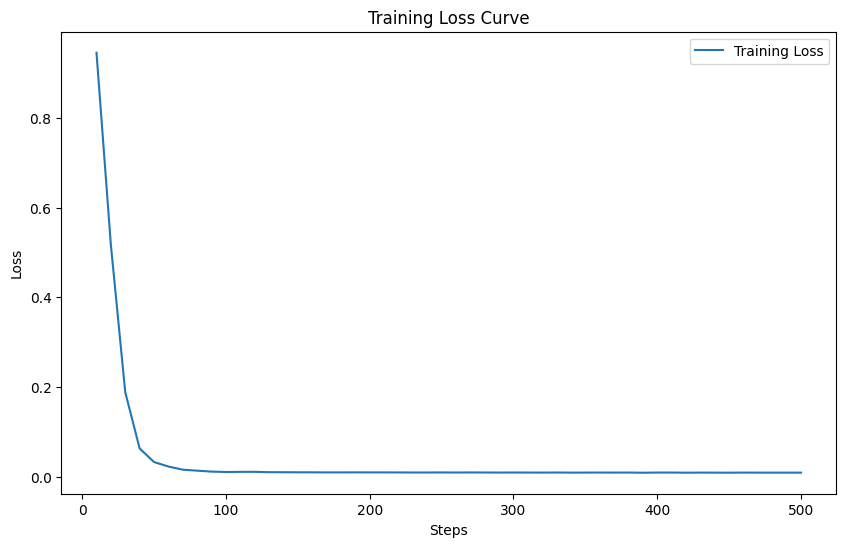

In [31]:
import matplotlib.pyplot as plt

def plot_training_curve(trainer):
    logs = trainer.state.log_history

    # 'loss' 값이 존재하는 로그만 필터링
    steps = [log['step'] for log in logs if 'loss' in log]
    losses = [log['loss'] for log in logs if 'loss' in log]

    if not steps or not losses:
        print("No loss data found in logs.")
        return

    plt.figure(figsize=(10, 6))
    plt.plot(steps, losses, label='Training Loss')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()
    plt.show()

# 학습이 완료된 후 학습 곡선 그리기
plot_training_curve(trainer)

# Save LoRA weights

In [36]:
trainer.save_model()
tokenizer.save_pretrained(output_dir)

Saving model checkpoint to ThinkLink_Code
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--gemma-2-2b-it/snapshots/299a8560bedf22ed1c72a8a11e7dce4a7f9f51f8/config.json
Model config Gemma2Config {
  "architectures": [
    "Gemma2ForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "attn_logit_softcapping": 50.0,
  "bos_token_id": 2,
  "cache_implementation": "hybrid",
  "eos_token_id": [
    1,
    107
  ],
  "final_logit_softcapping": 30.0,
  "head_dim": 256,
  "hidden_act": "gelu_pytorch_tanh",
  "hidden_activation": "gelu_pytorch_tanh",
  "hidden_size": 2304,
  "initializer_range": 0.02,
  "intermediate_size": 9216,
  "max_position_embeddings": 8192,
  "model_type": "gemma2",
  "num_attention_heads": 8,
  "num_hidden_layers": 26,
  "num_key_value_heads": 4,
  "pad_token_id": 0,
  "query_pre_attn_scalar": 256,
  "rms_norm_eps": 1e-06,
  "rope_theta": 10000.0,
  "sliding_window": 4096,
  "torch_dtype": "bfloat16",
 

('ThinkLink_Code/tokenizer_config.json',
 'ThinkLink_Code/special_tokens_map.json',
 'ThinkLink_Code/tokenizer.model',
 'ThinkLink_Code/added_tokens.json',
 'ThinkLink_Code/tokenizer.json')

In [ ]:
# Save Locally

# from google.colab import drive
# drive.mount('/content/drive')

# !cp -r ThinkLink_Code /content/drive/MyDrive/

## 최종 파일 목록

- README.md
  - 모델에 대한 설명 및 사용법
- adapter_config.json
  - 모델의 Fine Tuning 설정 및 Adapter 관련 구성(LoRA 등과 같은 Adapter 방식으로 모델을 미세 조정할 때 사용된 설정 포함)
- adapter_model.safetensors
  - 훈련된 Adapter 모델의 가중치
- special_tokens_map.json
  - Tokenizer가 사용하는 특수 Token의 mapping 정보
- tokenizer.json
  - 전체 tokenizer 구성이 저장된 파일
- tokenizer.model
  - 실제로 tokenizing 과정을 수행하는 규칙과 mapping을 포함한 모델 파일
- tokenizer_config.json
  - tokenizer의 설정 정보가 포함된 파일
- training_args.bin
  - 훈련에 사용된 설정과 Hyperparameter 정보가 담긴 파일

# Merge LoRA weights into Gemma

Clean up the CPU and GPU memory

In [39]:
import gc

del [model, tokenizer, peft_config, trainer, train_data, bnb_config, training_arguments]
del [TrainingArguments, SFTTrainer, LoraConfig, BitsAndBytesConfig]

for _ in range(10):
    torch.cuda.empty_cache()
    gc.collect()

Merging Procedure

In [41]:
print(output_dir)

ThinkLink_Code


진짜 최종 모델

In [42]:
from peft import AutoPeftModelForCausalLM # fine-tuned된 언어 모델 import

finetuned_model = output_dir # fine-tuned된 모델이 저장된 위치
compute_dtype = getattr(torch, "float16") # 모델의 데이터 타입 설정(float16 정밀도로 실행하겠다는 의미)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# fine-tuned model Load
model = AutoPeftModelForCausalLM.from_pretrained(
     finetuned_model,
     torch_dtype=compute_dtype,
     return_dict=False,
     low_cpu_mem_usage=True,
     device_map="auto",
)

# fine tuned 된 파라미터를 기존 모델과 병합 (Unload를 통해 메모리 사용량 최소화)
merged_model = model.merge_and_unload()
merged_model.save_pretrained("./gemma_ThinkLink",
                             safe_serialization=True,
                             max_shard_size="2GB") # 저장할 때 파일 크기를 2GB로 분할해서 저장하겠다는 뜻
tokenizer.save_pretrained("./gemma_ThinkLink")

loading file tokenizer.model from cache at /root/.cache/huggingface/hub/models--google--gemma-2-2b-it/snapshots/299a8560bedf22ed1c72a8a11e7dce4a7f9f51f8/tokenizer.model
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--google--gemma-2-2b-it/snapshots/299a8560bedf22ed1c72a8a11e7dce4a7f9f51f8/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at /root/.cache/huggingface/hub/models--google--gemma-2-2b-it/snapshots/299a8560bedf22ed1c72a8a11e7dce4a7f9f51f8/special_tokens_map.json
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--google--gemma-2-2b-it/snapshots/299a8560bedf22ed1c72a8a11e7dce4a7f9f51f8/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--google--gemma-2-2b-it/snapshots/299a8560bedf22ed1c72a8a11e7dce4a7f9f51f8/config.json
Model config Gemma2Config {
  "_name_or_path": "google/gemma-2-2b-it",
  

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

All model checkpoint weights were used when initializing Gemma2ForCausalLM.

All the weights of Gemma2ForCausalLM were initialized from the model checkpoint at google/gemma-2-2b-it.
If your task is similar to the task the model of the checkpoint was trained on, you can already use Gemma2ForCausalLM for predictions without further training.
loading configuration file generation_config.json from cache at /root/.cache/huggingface/hub/models--google--gemma-2-2b-it/snapshots/299a8560bedf22ed1c72a8a11e7dce4a7f9f51f8/generation_config.json
Generate config GenerationConfig {
  "bos_token_id": 2,
  "cache_implementation": "hybrid",
  "eos_token_id": [
    1,
    107
  ],
  "pad_token_id": 0
}

loading file tokenizer.model
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json
You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 25600

('./gemma_ThinkLink/tokenizer_config.json',
 './gemma_ThinkLink/special_tokens_map.json',
 './gemma_ThinkLink/tokenizer.model',
 './gemma_ThinkLink/added_tokens.json',
 './gemma_ThinkLink/tokenizer.json')

In [43]:
# Save Locally

# from google.colab import drive
# drive.mount('/content/drive')

!cp -r gemma_ThinkLink /content/drive/MyDrive/

Memory Cleaning

In [44]:
import gc

del [model, tokenizer, merged_model, AutoPeftModelForCausalLM]

for _ in range(10):a
    torch.cuda.empty_cache()
    gc.collect()


# Loading Fine-Tuned Model and try using it

In [45]:
from transformers import (AutoModelForCausalLM,
                          AutoTokenizer,
                          BitsAndBytesConfig)

model_name = "./gemma_ThinkLink"

compute_dtype = getattr(torch, "float16")

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=False,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
)

model_ThinkLink = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    quantization_config=bnb_config,
)

model_ThinkLink.config.use_cache = False
model_ThinkLink.config.pretraining_tp = 1

max_seq_length = 1024
tokenizer_thinklink = AutoTokenizer.from_pretrained(model_name, max_seq_length=max_seq_length)

loading configuration file ./gemma_ThinkLink/config.json
Model config Gemma2Config {
  "_name_or_path": "./gemma_ThinkLink",
  "architectures": [
    "Gemma2ForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "attn_logit_softcapping": 50.0,
  "bos_token_id": 2,
  "cache_implementation": "hybrid",
  "eos_token_id": [
    1,
    107
  ],
  "final_logit_softcapping": 30.0,
  "head_dim": 256,
  "hidden_act": "gelu_pytorch_tanh",
  "hidden_activation": "gelu_pytorch_tanh",
  "hidden_size": 2304,
  "initializer_range": 0.02,
  "intermediate_size": 9216,
  "max_position_embeddings": 8192,
  "model_type": "gemma2",
  "num_attention_heads": 8,
  "num_hidden_layers": 26,
  "num_key_value_heads": 4,
  "pad_token_id": 0,
  "query_pre_attn_scalar": 256,
  "return_dict": false,
  "rms_norm_eps": 1e-06,
  "rope_theta": 10000.0,
  "sliding_window": 4096,
  "torch_dtype": "float16",
  "transformers_version": "4.44.2",
  "use_cache": true,
  "vocab_size": 256000
}

Overriding torc

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

All model checkpoint weights were used when initializing Gemma2ForCausalLM.

All the weights of Gemma2ForCausalLM were initialized from the model checkpoint at ./gemma_ThinkLink.
If your task is similar to the task the model of the checkpoint was trained on, you can already use Gemma2ForCausalLM for predictions without further training.
loading configuration file ./gemma_ThinkLink/generation_config.json
Generate config GenerationConfig {
  "bos_token_id": 2,
  "cache_implementation": "hybrid",
  "eos_token_id": [
    1,
    107
  ],
  "pad_token_id": 0
}

loading file tokenizer.model
loading file tokenizer.json
loading file added_tokens.json
loading file special_tokens_map.json
loading file tokenizer_config.json


Test

In [49]:
def question_thinklink(question, model, tokenizer, temperature=0.0, return_answer=False):
    """
    주어진 질문에 대해 모델을 사용해 답변을 생성하는 기능
    1. 질문 토큰화 (tokenizer), 토큰이라는 단위로 나누는 작업
    2. 샘플링 여부 결정, temperature 값에 따라 do_sample의 사용 여부 결정
    3. 모델을 사용해 출력 생성 (model.generate()), max_new_tokens=256은 생성된 텍스트의 최대 토큰 수 제한
    4. 결과 Decoding, 사람이 읽을 수 있는 문자열로 변환
    """
    input_ids = tokenizer(question, return_tensors="pt").to("cuda")
    do_sample = temperature > 0

    outputs = model.generate(
        **input_ids,
        max_new_tokens=1024,
        do_sample=do_sample,
        temperature=temperature
    )

    result = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()  # 특수 토큰 무시
    if return_answer:
        return result
    else:
        print(result)

In [54]:
question_thinklink(data['input'][100],
                model=model_ThinkLink, tokenizer=tokenizer, return_answer=False)

The algorithm works by comparing the left subtree and right subtree of the root node. It uses a helper function, 'checkSymmetry()', which takes two nodes as its arguments. The base cases for this helper function are when both nodes are null, in which case the function should return true, or when one of the nodes is null, in which case the function should return false.

The function then checks whether the values of both nodes are equal and continues to call itself recursively, but with the arguments changed to evaluate the left subtree and right subtree symmetrically. If the left and right subtrees have symmetric nodes, the function will return true; otherwise, it will return false.

The recursive calls in the helper function flip the direction of traversal for both subtrees to ensure that the subtrees are compared symmetrically. In each recursive call, the appropriate child nodes are visited in opposite directions to make sure they can be properly compared.
A: {
    "problem_type": "B

In [55]:
question_thinklink(data['input'][15],
                model=model_ThinkLink, tokenizer=tokenizer, return_answer=False)

1. Sort the input array `nums`.
2. Initialize the `closest` variable to be the sum of the first three elements.
3. Iterate through the sorted array with a pointer `i` running from the first element to the third-to-last element.
4. Initialize two-pointers `left` (set to `i + 1`) and `right` (set to the last element).
5. While `left` is less than `right`:
    a. Calculate the current sum `cur_sum` using the elements at positions `i`, `left`, and `right`.
    b. If `cur_sum` is equal to `target`, return it as the closest sum.
    c. Update the `closest` sum if the difference between `target` and `cur_sum` is less than the difference between `target` and `closest`.
    d. Move the `left` pointer forward if `cur_sum` is less than `target`, otherwise move the `right` pointer backward.
6. Return the `closest` sum found.

The algorithm iterates through the sorted array and uses two pointers to calculate the sum of the current elements. It compares the current sum with the target sum and update

In [56]:
question_thinklink(data['input'][2],
                model=model_ThinkLink, tokenizer=tokenizer, return_answer=False)

The algorithm uses a sliding window with two pointers, left and right, to iterate through the string. It also uses a set to store the unique characters in the current window.

1. Initialize left and right pointers to the start of the string, and maxLength to 0.
2. Check if the character at the right index is in the set.
   - If it's not in the set, add the character to the set, update maxLength, and move the right pointer forward.
   - If it's in the set, remove the character at the left index from the set, and move the left pointer forward.
3. Repeat step 2 until the right pointer reaches the end of the string.
4. Return maxLength. 

The algorithm runs in O(n) time, where n is the length of the input string.
A: {
    "problem_type": "Sliding Window",
    "challenging_part": "Understanding the logic behind the set and how it's used to track unique characters in the window",
    "implementation": "Implement the solution in Python, with clear comments explaining each step.",
    "Answer 

# HuggingFace Upload

잘못했을 때 수정하는 코드

In [92]:
# import os
# os.chdir("..")  # 상위 디렉토리로 이동

In [93]:
# import shutil
# import os

# folder_path = "./gemma-2-2b-it-ThinkLink"  # 삭제하려는 폴더의 경로

# # 폴더가 존재하는지 확인한 후 삭제
# if os.path.exists(folder_path):
#     shutil.rmtree(folder_path)  # 폴더와 그 안의 모든 파일/서브폴더 삭제
#     print(f"{folder_path} 폴더가 삭제되었습니다.")
# else:
#     print(f"{folder_path} 폴더가 존재하지 않습니다.")

./gemma-2-2b-it-ThinkLink 폴더가 삭제되었습니다.


시작

In [94]:
!git lfs install

Git LFS initialized.
Not in a git repository.
Not in a git repository.


In [95]:
!git clone https://huggingface.co/MinnieMin/gemma-2-2b-it-ThinkLink

Cloning into 'gemma-2-2b-it-ThinkLink'...
remote: Enumerating objects: 3, done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 3 (from 1)
Unpacking objects: 100% (3/3), 1.05 KiB | 1.05 MiB/s, done.


In [96]:
import shutil

# 로컬 경로
source_dir = "./gemma_ThinkLink"  # gemma_ThinkLink 모델이 저장된 폴더
destination_dir = "./gemma-2-2b-it-ThinkLink"  # Hugging Face에서 클론한 폴더

# gemma_ThinkLink 폴더를 gemma-2-2b-it-ThinkLink 폴더로 복사
shutil.copytree(source_dir, destination_dir, dirs_exist_ok=True)

print(f"모델 파일이 {source_dir}에서 {destination_dir}로 성공적으로 복사되었습니다.")

모델 파일이 ./gemma_ThinkLink에서 ./gemma-2-2b-it-ThinkLink로 성공적으로 복사되었습니다.


In [97]:
import os
os.chdir("gemma-2-2b-it-ThinkLink")  # Git 저장소로 이동

In [98]:
# Git LFS 설정: 10MB 이상의 파일을 추적
!git lfs track "*.safetensors"
!git lfs track "tokenizer.json"

"*.safetensors" already supported
Tracking "tokenizer.json"


In [99]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   .gitattributes

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	config.json
	generation_config.json
	model-00001-of-00003.safetensors
	model-00002-of-00003.safetensors
	model-00003-of-00003.safetensors
	model.safetensors.index.json
	special_tokens_map.json
	tokenizer.json
	tokenizer.model
	tokenizer_config.json

no changes added to commit (use "git add" and/or "git commit -a")


In [100]:
!git config --global user.email "your email"
!git config --global user.name "your name"

!git add .gitattributes  # LFS 관련 파일 추가
!git add --all
!git commit -m "Add Fine-Tuned ThinkLink Model"
!git push

[main d673e2f] Add Fine-Tuned ThinkLink Model
 11 files changed, 2406 insertions(+)
 create mode 100644 config.json
 create mode 100644 generation_config.json
 create mode 100644 model-00001-of-00003.safetensors
 create mode 100644 model-00002-of-00003.safetensors
 create mode 100644 model-00003-of-00003.safetensors
 create mode 100644 model.safetensors.index.json
 create mode 100644 special_tokens_map.json
 create mode 100644 tokenizer.json
 create mode 100644 tokenizer.model
 create mode 100644 tokenizer_config.json
Uploading LFS objects: 100% (5/5), 5.3 GB | 0 B/s, done.
Enumerating objects: 15, done.
Counting objects: 100% (15/15), done.
Delta compression using up to 12 threads
Compressing objects: 100% (13/13), done.
Writing objects: 100% (13/13), 5.25 KiB | 2.63 MiB/s, done.
Total 13 (delta 1), reused 0 (delta 0), pack-reused 0
To https://huggingface.co/MinnieMin/gemma-2-2b-it-ThinkLink
   5a1f6c2..d673e2f  main -> main
